In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import math
from keras.utils import Sequence

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [4]:
class ImageDataGenerator(Sequence):
    def __init__(self, df, batch_size, validation_fold, is_val=False):
        self.df = df[df.fold!=validation_fold] if not is_val else df[df.fold==validation_fold]
        self.bsz = batch_size # batch size
        self.labels = self.df[['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']].values
        self.im_list = self.df[['slice_file_name','fold']].values

    def __len__(self):
        return int(math.ceil(len(self.df) / float(self.bsz)))

    def get_batch_labels(self, idx):
        return self.labels[idx * self.bsz: (idx + 1) * self.bsz]

    def get_batch_features(self, idx):
        return np.array([plt.imread('data/{0}/{1}'.format(fold, im[:-4]+'.png')) for im, fold in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [5]:
data = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
data = (pd.concat([data, pd.get_dummies(data['class'])],axis=1)).drop(columns = ['fsID','start','end','classID','class'],axis=1)

In [6]:
input_layer = Input(shape=(240, 320, 1))
first_conv = Conv2D(filters=16, kernel_size=3, activation='relu')(input_layer)
first_pool = MaxPooling2D(pool_size=(2,2))(first_conv)
sec_conv = Conv2D(filters=32, kernel_size=3, activation='relu')(first_pool)
sec_pool = MaxPooling2D(pool_size=(2,2))(sec_conv)
third_conv = Conv2D(filters=64, kernel_size=3, activation='relu')(sec_pool)
third_pool = MaxPooling2D(pool_size=(2,2))(third_conv)
fourth_conv = Conv2D(filters=64, kernel_size=3, activation='relu')(third_pool)
fourth_pool = MaxPooling2D(pool_size=(2,2))(fourth_conv)
flattened = Flatten()(fourth_pool)
dropped = Dropout(0.5)(flattened)
dense = Dense(256, activation='relu')(dropped)
output_layer = Dense(10, activation='softmax')(dense)

model = Model(inputs = input_layer, outputs = output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 238, 318, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 64)        18496 

In [7]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
model_weights = model.get_weights()

Epoch 1/50
246/246 [==============================] - 24s 82ms/step - loss: 2.1504 - accuracy: 0.2075 - val_loss: 1.6598 - val_accuracy: 0.4490
Epoch 2/50
246/246 [==============================] - 18s 73ms/step - loss: 1.6166 - accuracy: 0.4138 - val_loss: 1.3898 - val_accuracy: 0.4983
Epoch 3/50
246/246 [==============================] - 20s 83ms/step - loss: 1.3387 - accuracy: 0.5146 - val_loss: 1.4347 - val_accuracy: 0.4330
Epoch 4/50
246/246 [==============================] - 17s 71ms/step - loss: 1.1516 - accuracy: 0.5933 - val_loss: 1.2955 - val_accuracy: 0.5922
Epoch 5/50
246/246 [==============================] - 17s 70ms/step - loss: 0.9211 - accuracy: 0.6648 - val_loss: 1.1062 - val_accuracy: 0.6964
Epoch 6/50
246/246 [==============================] - 18s 73ms/step - loss: 0.8129 - accuracy: 0.7029 - val_loss: 1.0516 - val_accuracy: 0.6735
Epoch 7/50
246/246 [==============================] - 18s 72ms/step - loss: 0.6764 - accuracy: 0.7621 - val_loss: 1.0721 - val_accuracy:

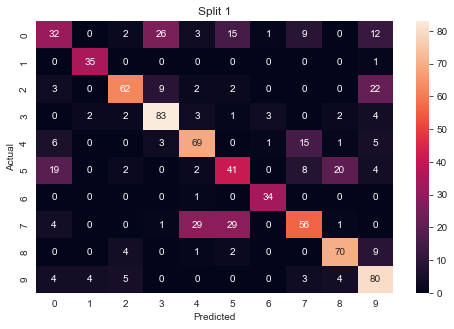

Epoch 1/50
246/246 [==============================] - 16s 66ms/step - loss: 2.2117 - accuracy: 0.1951 - val_loss: 1.9144 - val_accuracy: 0.2804
Epoch 2/50
246/246 [==============================] - 16s 64ms/step - loss: 1.7138 - accuracy: 0.3878 - val_loss: 1.4785 - val_accuracy: 0.4662
Epoch 3/50
246/246 [==============================] - 16s 64ms/step - loss: 1.4233 - accuracy: 0.5055 - val_loss: 1.3770 - val_accuracy: 0.4516
Epoch 4/50
246/246 [==============================] - 16s 64ms/step - loss: 1.1310 - accuracy: 0.5936 - val_loss: 1.1884 - val_accuracy: 0.5327
Epoch 5/50
246/246 [==============================] - 17s 68ms/step - loss: 0.9832 - accuracy: 0.6512 - val_loss: 1.0835 - val_accuracy: 0.5563
Epoch 6/50
246/246 [==============================] - 16s 64ms/step - loss: 0.8156 - accuracy: 0.7137 - val_loss: 1.0688 - val_accuracy: 0.5833
Epoch 7/50
246/246 [==============================] - 16s 65ms/step - loss: 0.7173 - accuracy: 0.7525 - val_loss: 1.1164 - val_accuracy:

<Figure size 432x288 with 0 Axes>

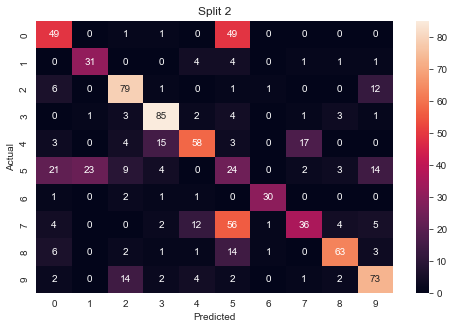

Epoch 1/50
244/244 [==============================] - 17s 69ms/step - loss: 2.2073 - accuracy: 0.1769 - val_loss: 1.8962 - val_accuracy: 0.3568
Epoch 2/50
244/244 [==============================] - 16s 64ms/step - loss: 1.8244 - accuracy: 0.3569 - val_loss: 1.4526 - val_accuracy: 0.5038
Epoch 3/50
244/244 [==============================] - 17s 70ms/step - loss: 1.4468 - accuracy: 0.4934 - val_loss: 1.2923 - val_accuracy: 0.5211
Epoch 4/50
244/244 [==============================] - 15s 63ms/step - loss: 1.2330 - accuracy: 0.5553 - val_loss: 1.1992 - val_accuracy: 0.5805
Epoch 5/50
244/244 [==============================] - 16s 63ms/step - loss: 1.0744 - accuracy: 0.6038 - val_loss: 1.1849 - val_accuracy: 0.5481
Epoch 6/50
244/244 [==============================] - 16s 63ms/step - loss: 0.9235 - accuracy: 0.6721 - val_loss: 1.2128 - val_accuracy: 0.5859
Epoch 7/50
244/244 [==============================] - 15s 63ms/step - loss: 0.8090 - accuracy: 0.7138 - val_loss: 1.2427 - val_accuracy:

<Figure size 432x288 with 0 Axes>

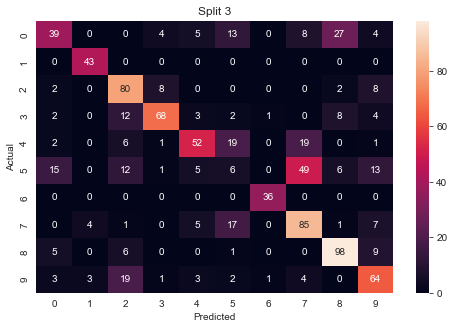

Epoch 1/50
242/242 [==============================] - 18s 73ms/step - loss: 2.2897 - accuracy: 0.1472 - val_loss: 2.2160 - val_accuracy: 0.1596
Epoch 2/50
242/242 [==============================] - 18s 75ms/step - loss: 1.9996 - accuracy: 0.2595 - val_loss: 1.9225 - val_accuracy: 0.3535
Epoch 3/50
242/242 [==============================] - 19s 78ms/step - loss: 1.7480 - accuracy: 0.3575 - val_loss: 1.7788 - val_accuracy: 0.4030
Epoch 4/50
242/242 [==============================] - 18s 76ms/step - loss: 1.5712 - accuracy: 0.4241 - val_loss: 1.7172 - val_accuracy: 0.4141
Epoch 5/50
242/242 [==============================] - 16s 66ms/step - loss: 1.3155 - accuracy: 0.5282 - val_loss: 1.6377 - val_accuracy: 0.4636
Epoch 6/50
242/242 [==============================] - 16s 65ms/step - loss: 1.1078 - accuracy: 0.6104 - val_loss: 1.4389 - val_accuracy: 0.5333
Epoch 7/50
242/242 [==============================] - 16s 65ms/step - loss: 0.9411 - accuracy: 0.6732 - val_loss: 1.4811 - val_accuracy:

<Figure size 432x288 with 0 Axes>

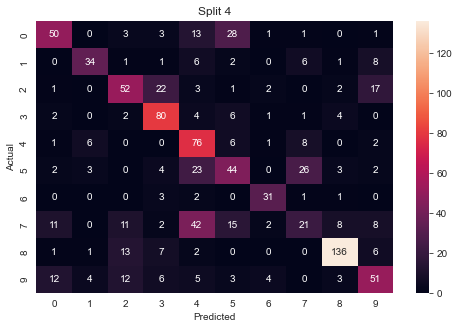

Epoch 1/50
244/244 [==============================] - 16s 67ms/step - loss: 2.3092 - accuracy: 0.0908 - val_loss: 2.3178 - val_accuracy: 0.1068
Epoch 2/50
244/244 [==============================] - 15s 63ms/step - loss: 2.2405 - accuracy: 0.1469 - val_loss: 2.1528 - val_accuracy: 0.2489
Epoch 3/50
244/244 [==============================] - 15s 63ms/step - loss: 1.9761 - accuracy: 0.2658 - val_loss: 1.7097 - val_accuracy: 0.3291
Epoch 4/50
244/244 [==============================] - 15s 63ms/step - loss: 1.7844 - accuracy: 0.3539 - val_loss: 1.6256 - val_accuracy: 0.4658
Epoch 5/50
244/244 [==============================] - 15s 63ms/step - loss: 1.5753 - accuracy: 0.4474 - val_loss: 1.3649 - val_accuracy: 0.5288
Epoch 6/50
244/244 [==============================] - 15s 63ms/step - loss: 1.3579 - accuracy: 0.5177 - val_loss: 1.2910 - val_accuracy: 0.5620
Epoch 7/50
244/244 [==============================] - 15s 63ms/step - loss: 1.0971 - accuracy: 0.6189 - val_loss: 1.1758 - val_accuracy:

<Figure size 432x288 with 0 Axes>

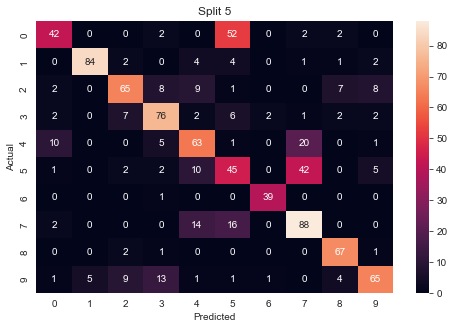

Epoch 1/50
248/248 [==============================] - 20s 79ms/step - loss: 2.3012 - accuracy: 0.1062 - val_loss: 2.2022 - val_accuracy: 0.1495
Epoch 2/50
248/248 [==============================] - 18s 71ms/step - loss: 2.0890 - accuracy: 0.2234 - val_loss: 2.0731 - val_accuracy: 0.2515
Epoch 3/50
248/248 [==============================] - 17s 67ms/step - loss: 1.8040 - accuracy: 0.3018 - val_loss: 1.7016 - val_accuracy: 0.3767
Epoch 4/50
248/248 [==============================] - 16s 65ms/step - loss: 1.5555 - accuracy: 0.4161 - val_loss: 1.6485 - val_accuracy: 0.4156
Epoch 5/50
248/248 [==============================] - 17s 69ms/step - loss: 1.3634 - accuracy: 0.4987 - val_loss: 1.6215 - val_accuracy: 0.4447
Epoch 6/50
248/248 [==============================] - 18s 73ms/step - loss: 1.1857 - accuracy: 0.5821 - val_loss: 1.7446 - val_accuracy: 0.4848
Epoch 7/50
248/248 [==============================] - 17s 69ms/step - loss: 1.0511 - accuracy: 0.6244 - val_loss: 1.6925 - val_accuracy:

<Figure size 432x288 with 0 Axes>

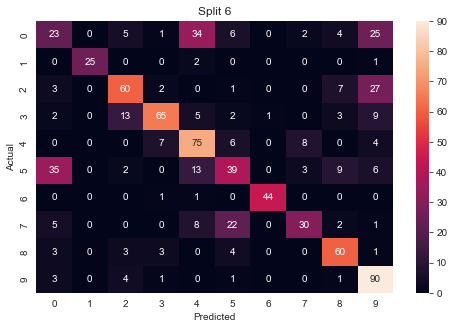

Epoch 1/50
247/247 [==============================] - 18s 71ms/step - loss: 2.2894 - accuracy: 0.1236 - val_loss: 2.2121 - val_accuracy: 0.1337
Epoch 2/50
247/247 [==============================] - 16s 63ms/step - loss: 1.9772 - accuracy: 0.3054 - val_loss: 1.8988 - val_accuracy: 0.3174
Epoch 3/50
247/247 [==============================] - 16s 64ms/step - loss: 1.6263 - accuracy: 0.4173 - val_loss: 1.7468 - val_accuracy: 0.4320
Epoch 4/50
247/247 [==============================] - 16s 63ms/step - loss: 1.3984 - accuracy: 0.5034 - val_loss: 1.6810 - val_accuracy: 0.4153
Epoch 5/50
247/247 [==============================] - 16s 63ms/step - loss: 1.1628 - accuracy: 0.5788 - val_loss: 1.5439 - val_accuracy: 0.4690
Epoch 6/50
247/247 [==============================] - 16s 63ms/step - loss: 0.9298 - accuracy: 0.6648 - val_loss: 1.4460 - val_accuracy: 0.5382
Epoch 7/50
247/247 [==============================] - 16s 63ms/step - loss: 0.7735 - accuracy: 0.7337 - val_loss: 1.6170 - val_accuracy:

<Figure size 432x288 with 0 Axes>

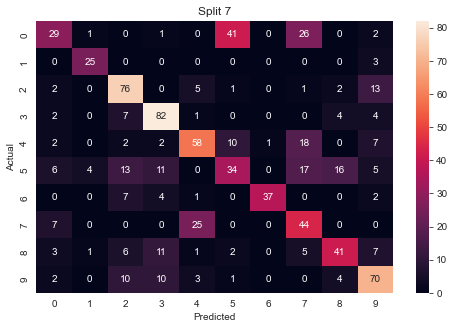

Epoch 1/50
248/248 [==============================] - 17s 69ms/step - loss: 2.2318 - accuracy: 0.1630 - val_loss: 1.9182 - val_accuracy: 0.3102
Epoch 2/50
248/248 [==============================] - 17s 67ms/step - loss: 1.8782 - accuracy: 0.2880 - val_loss: 1.5913 - val_accuracy: 0.4181
Epoch 3/50
248/248 [==============================] - 17s 67ms/step - loss: 1.5591 - accuracy: 0.4333 - val_loss: 1.6580 - val_accuracy: 0.4156
Epoch 4/50
248/248 [==============================] - 17s 67ms/step - loss: 1.3425 - accuracy: 0.5300 - val_loss: 1.1583 - val_accuracy: 0.5347
Epoch 5/50
248/248 [==============================] - 17s 67ms/step - loss: 1.1811 - accuracy: 0.5836 - val_loss: 1.1779 - val_accuracy: 0.5347
Epoch 6/50
248/248 [==============================] - 17s 67ms/step - loss: 1.0623 - accuracy: 0.6185 - val_loss: 1.1476 - val_accuracy: 0.5720
Epoch 7/50
248/248 [==============================] - 16s 64ms/step - loss: 0.9473 - accuracy: 0.6652 - val_loss: 1.2596 - val_accuracy:

<Figure size 432x288 with 0 Axes>

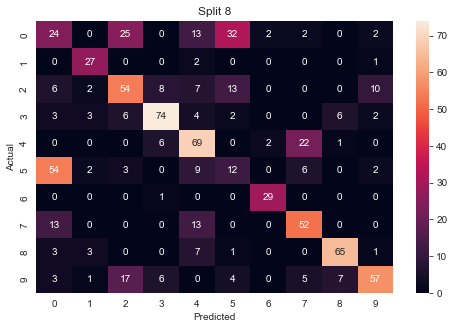

Epoch 1/50
248/248 [==============================] - 17s 70ms/step - loss: 2.1755 - accuracy: 0.1992 - val_loss: 1.9202 - val_accuracy: 0.2316
Epoch 2/50
248/248 [==============================] - 16s 66ms/step - loss: 1.8090 - accuracy: 0.3421 - val_loss: 1.5611 - val_accuracy: 0.4436
Epoch 3/50
248/248 [==============================] - 16s 65ms/step - loss: 1.4551 - accuracy: 0.4794 - val_loss: 1.2022 - val_accuracy: 0.5453
Epoch 4/50
248/248 [==============================] - 16s 66ms/step - loss: 1.2307 - accuracy: 0.5538 - val_loss: 1.1348 - val_accuracy: 0.5539
Epoch 5/50
248/248 [==============================] - 16s 65ms/step - loss: 1.0764 - accuracy: 0.6187 - val_loss: 1.1691 - val_accuracy: 0.6409
Epoch 6/50
248/248 [==============================] - 16s 64ms/step - loss: 0.9217 - accuracy: 0.6659 - val_loss: 1.1916 - val_accuracy: 0.6360
Epoch 7/50
248/248 [==============================] - 16s 65ms/step - loss: 0.7899 - accuracy: 0.7150 - val_loss: 1.1110 - val_accuracy:

<Figure size 432x288 with 0 Axes>

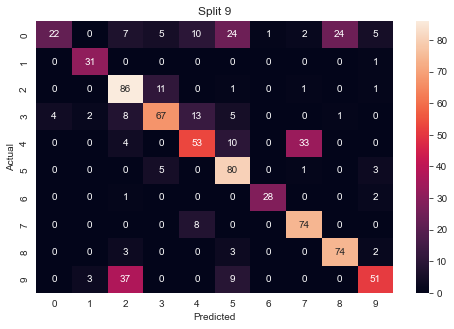

Epoch 1/50
247/247 [==============================] - 17s 67ms/step - loss: 2.2111 - accuracy: 0.1478 - val_loss: 1.8769 - val_accuracy: 0.2258
Epoch 2/50
247/247 [==============================] - 16s 65ms/step - loss: 1.7704 - accuracy: 0.3408 - val_loss: 1.6242 - val_accuracy: 0.4815
Epoch 3/50
247/247 [==============================] - 16s 66ms/step - loss: 1.4375 - accuracy: 0.4892 - val_loss: 1.4631 - val_accuracy: 0.5281
Epoch 4/50
247/247 [==============================] - 16s 66ms/step - loss: 1.1894 - accuracy: 0.5677 - val_loss: 1.3525 - val_accuracy: 0.5424
Epoch 5/50
247/247 [==============================] - 16s 64ms/step - loss: 1.0405 - accuracy: 0.6129 - val_loss: 1.3591 - val_accuracy: 0.5185
Epoch 6/50
247/247 [==============================] - 16s 65ms/step - loss: 0.9024 - accuracy: 0.6760 - val_loss: 1.2892 - val_accuracy: 0.5771
Epoch 7/50
247/247 [==============================] - 18s 73ms/step - loss: 0.8352 - accuracy: 0.7047 - val_loss: 1.2982 - val_accuracy:

<Figure size 432x288 with 0 Axes>

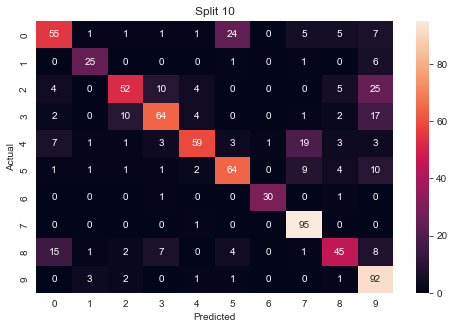

<Figure size 432x288 with 0 Axes>

In [10]:
histories = []
for i in range(10):
    model_save = ModelCheckpoint('saved_models/best_model_{}.hdf5'.format(i+1), save_best_only=True)
    model.set_weights(model_weights)
    train = ImageDataGenerator(data , 32, i+1)
    test = ImageDataGenerator(data, 32, i+1, is_val=True)
    history = model.fit(train , validation_data =test,callbacks=[early_stopping,model_save], epochs=50)
    model.evaluate(test)
    pred = model.predict(test)
    histories.append(history)
    fig, ax = plt.subplots(figsize=(8,5))
    test_df = data[data.fold==i+1][['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']].values
    sns.heatmap(confusion_matrix(np.argmax(test_df,axis=1), np.argmax(pred,axis=1)), annot=True, fmt=".0f", ax=ax)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Split {}'.format(i+1))
    plt.savefig('results/confusion_matrix_{}.png'.format(i+1))
    plt.show()
    plt.clf()

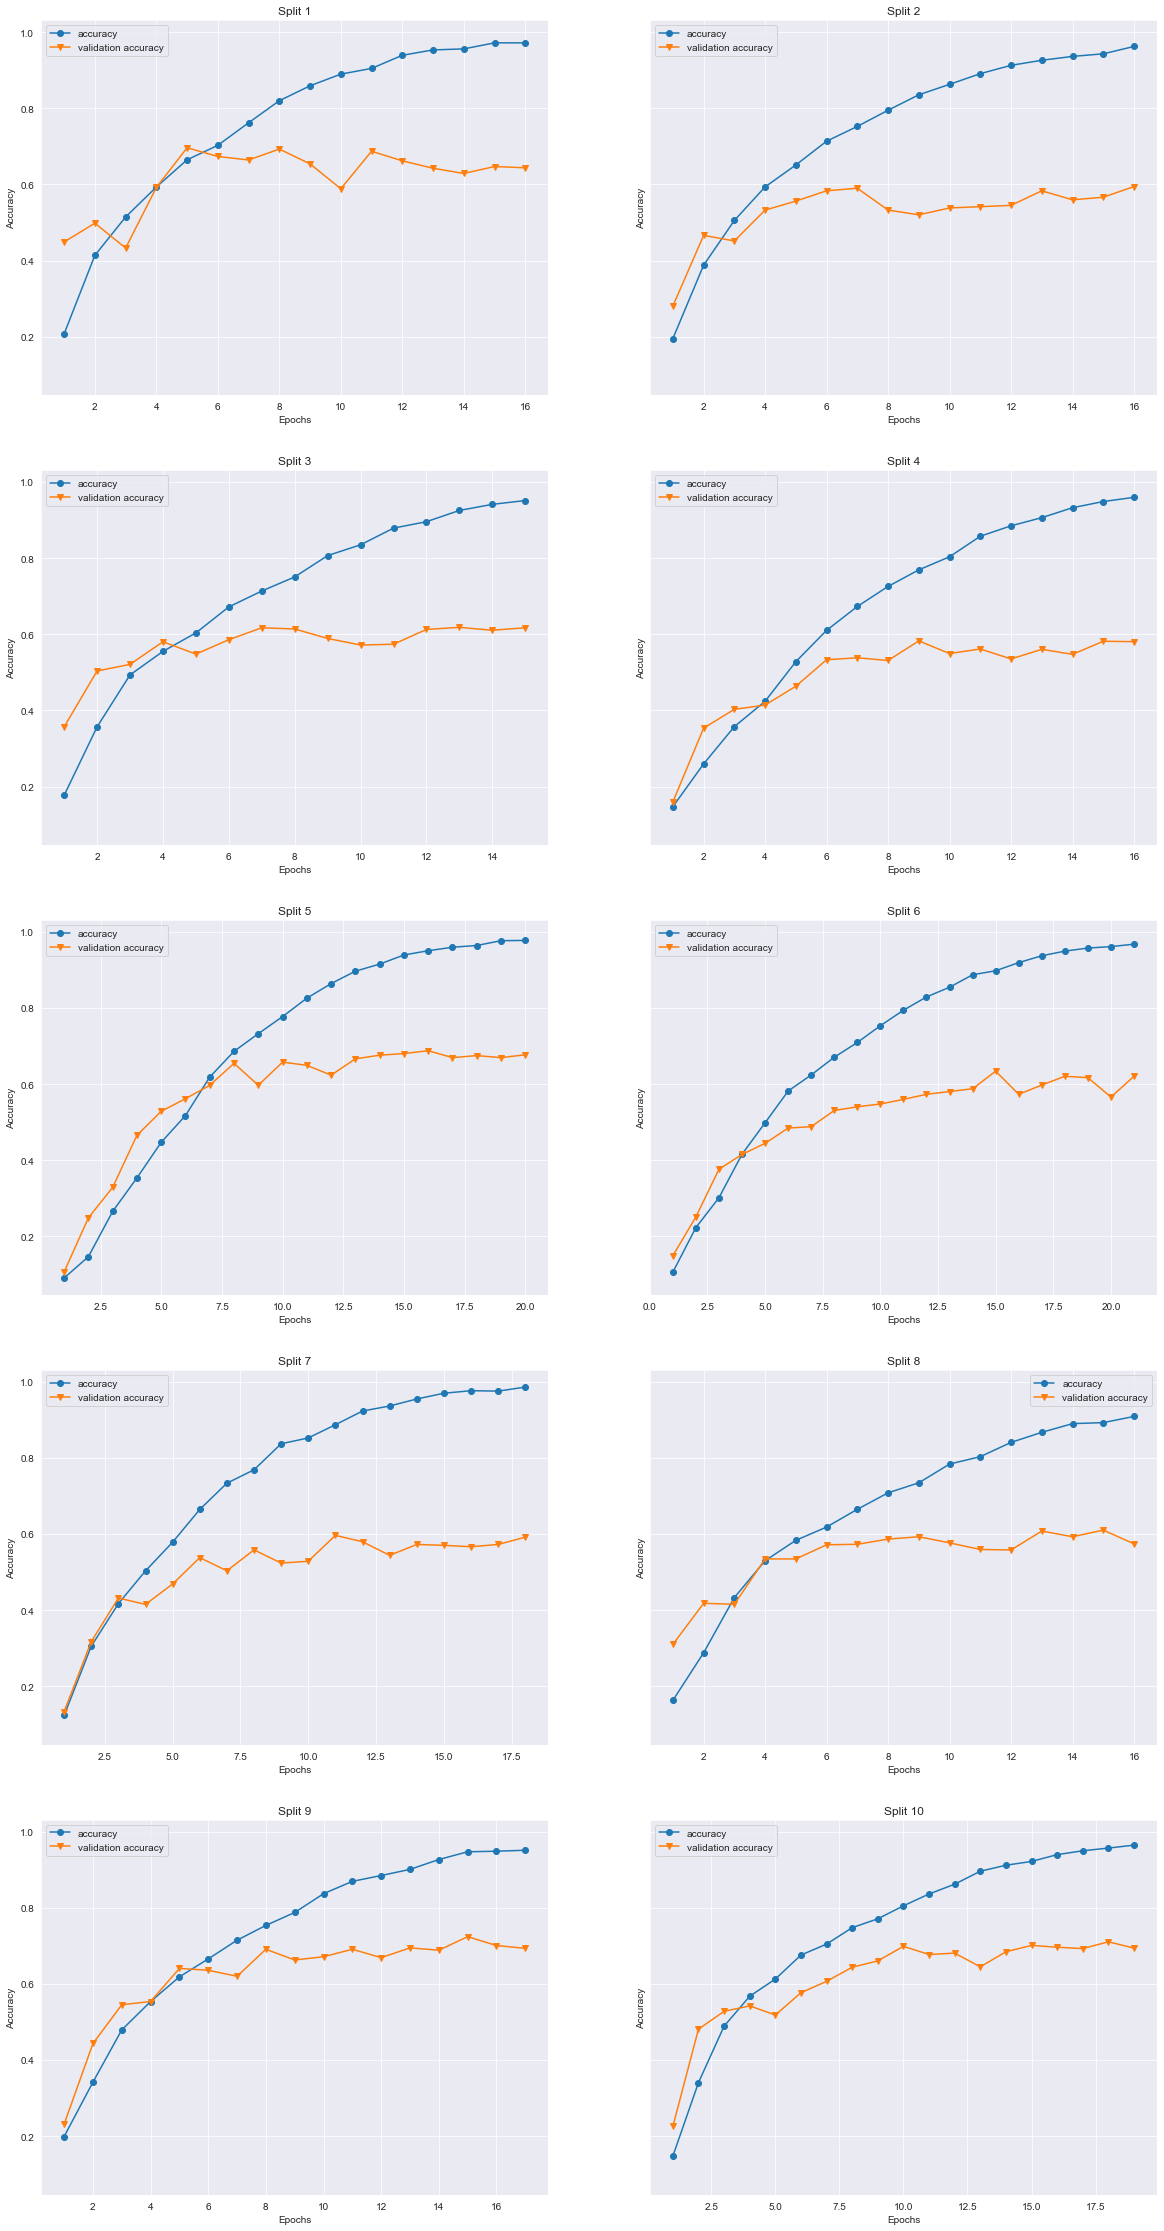

In [53]:
split = 0
fig, ax = plt.subplots(5,2, figsize=(20,40), sharey=True)
sum = 0
maximum = 0
minimum = 1
for history in histories:
    ax[split//2][split%2].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'], marker='o',label='accuracy')
    ax[split//2][split%2].plot(range(1,len(history.history['accuracy'])+1), history.history['val_accuracy'], marker='v', label='validation accuracy')
    ax[split//2][split%2].set_title('Split ' + str(split+1))
    ax[split//2][split%2].legend()
    ax[split//2][split%2].set_xlabel('Epochs')
    ax[split//2][split%2].set_ylabel('Accuracy')
    split+=1
    val_acc = history.history['val_accuracy'][-1]
    sum += val_acc
    maximum = maximum if val_acc < maximum else val_acc
    minimum = minimum if val_acc > minimum else val_acc
plt.show()

In [39]:
print('Average validation accuracy: ' + str(sum/10))

Average validation accuracy: 0.6288807034492493


In [40]:
print('Maximum validation accuracy: ' + str(maximum))

Maximum validation accuracy: 0.6941457390785217


In [41]:
print('Minimum validation accuracy: ' + str(minimum))

Minimum validation accuracy: 0.57444167137146
